In [1]:
pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [19]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt

In [6]:
y_binary = y["y"].map({"yes": 1, "no": 0})

In [7]:
categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(exclude=["object"]).columns

print("Categorical Columns:", len(categorical_cols))
print("Numerical Columns:", len(numerical_cols))

Categorical Columns: 9
Numerical Columns: 7


In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_binary,
    test_size=0.25,
    random_state=42,
    stratify=y_binary
)

In [10]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [11]:
y_prob = model.predict_proba(X_test)[:, 1]


In [12]:
def evaluate_model(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    return cm, precision, recall, specificity, f1

In [13]:
cm, precision, recall, specificity, f1 = evaluate_model(
    y_test, y_prob, threshold=0.5
)

print("Threshold = 0.5")
print("Confusion Matrix:\n", cm)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1 Score:", f1)

Threshold = 0.5
Confusion Matrix:
 [[9723  258]
 [ 857  465]]
Precision: 0.6431535269709544
Recall (Sensitivity): 0.3517397881996974
Specificity: 0.974150886684701
F1 Score: 0.4547677261613692


ROC-AUC: 0.906139971543512


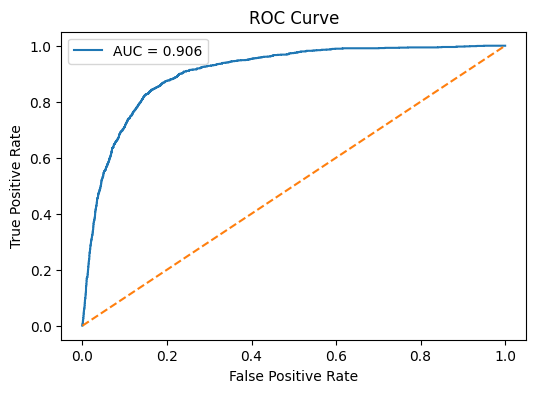

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

print("ROC-AUC:", roc_auc)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [15]:
youden_j = tpr - fpr
best_index = youden_j.argmax()
best_threshold = thresholds[best_index]

print("Optimized Threshold:", best_threshold)

Optimized Threshold: 0.11174812194665963


In [16]:
cm_opt, p_opt, r_opt, s_opt, f1_opt = evaluate_model(
    y_test, y_prob, threshold=best_threshold
)

print("Optimized Threshold Metrics")
print("Confusion Matrix:\n", cm_opt)
print("Precision:", p_opt)
print("Recall (Sensitivity):", r_opt)
print("Specificity:", s_opt)
print("F1 Score:", f1_opt)

Optimized Threshold Metrics
Confusion Matrix:
 [[8349 1632]
 [ 207 1115]]
Precision: 0.40589734255551513
Recall (Sensitivity): 0.8434190620272315
Specificity: 0.8364893297264803
F1 Score: 0.5480462029982797


In [17]:
prob_df = pd.DataFrame({
    "RecordId": y_test.index,
    "Probability(yes)": y_prob,
    "PredictedLabel": (y_prob >= best_threshold).astype(int)
})

prob_df.to_csv("probabilities.csv", index=False)
print("probabilities.csv generated successfully")

probabilities.csv generated successfully


In [23]:
from google.colab.patches import cv2_imshow
import cv2 # Ensure cv2 is imported here if not globally

img2 = cv2.imread("dec.png")

if img2 is not None:
    cv2_imshow(img2)
else:
    print("Error: 'dec.png' not found or could not be loaded. Please ensure the file exists.")

Error: 'dec.png' not found or could not be loaded. Please ensure the file exists.


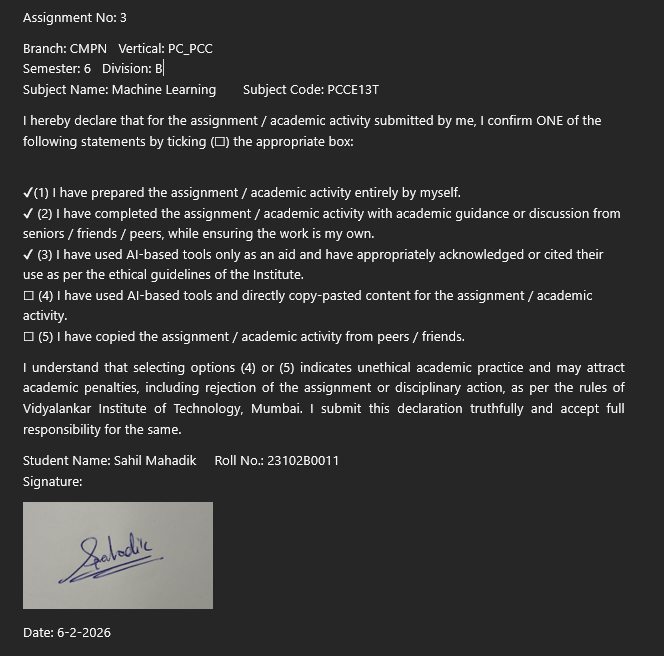

In [26]:
from google.colab.patches import cv2_imshow
import cv2
img_to_display = cv2.imread("img.png")
cv2_imshow(img_to_display)